# Data processing

In this code, we create two datasets for the two phases of our Flooding-Filling model training. This
pre-processing is based on [[1]](https://www.earthdoc.org/content/papers/10.3997/2214-4609.201800237).

The first dataset, refered as `db01`, contains features comprising the amplitudes on the first channel, and the center part of the label on the second channel. The idea is to train the model to complete the horizon segment
from a centered annotation; imagine a user marking only a few seeds on the seismic, or we starting from well tops.

The second dataset, called `db02`, has its features containing amplitudes on the first channel, and partial label annotations on the second channel. Now, the idea is to train the model to track the horizons.

> The `rockml` library imported in this script will be made available at some point in the near future.

In [1]:
%matplotlib notebook

import json
import os
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import yaml
from rockml.data.adapter import Datum
from rockml.data.adapter.seismic.segy import PostStackDataDumper
from rockml.data.adapter.seismic.segy.poststack import PostStackAdapter2D, PostStackDatum
from rockml.data.array_ops import crop_2d
from rockml.data.pipeline import Pipeline
from rockml.data.sampling import split_dataset
from rockml.data.transformations import Composer, Transformation
from rockml.data.transformations.seismic import image

def makedir(path: str):
    """ Wrapper to create all the necessary directories in *path* with user/group rights to
        read, write and execute.
    Args:
        path: (str) path to the directory to be created.
    """

    os.makedirs(path, mode=0o770, exist_ok=True)

In [2]:
params = dict()
params['output_path'] = '/home/sallesd/ffn_dataset'
params['segy_info'] = yaml.safe_load(
    open('/home/sallesd/f3_info/info.yml')
)
params['train_slices'] = yaml.safe_load(
    open('/home/sallesd/f3_info/train_20.yml')
)
params['test_slices'] = yaml.safe_load(
    open('/home/sallesd/f3_info/test_20.yml')
)
params['tile_shape'] = (64, 64)
params['stride_shape'] = (8, 8)
params['gray_levels'] = 256
params['crop'] = (0, 0, 75, 0)
params['percentile'] = 5.0
params['valid_ratio'] = 0.1
params['cores'] = 20

params['horizons_path_list'] = [
    line['path'] for line in params['segy_info']['horizon_pixel_ranges']
]
makedir(params['output_path'])

adapter = PostStackAdapter2D(
    segy_path=params['segy_info']['segy_path'],
    horizons_path_list=params['horizons_path_list'],
    data_dict=params['train_slices']
)
adapter.initial_scan()

{'range_inlines': [100, 750],
 'range_crosslines': [300, 1250],
 'num_inlines': 651,
 'num_crosslines': 951,
 'range_time_depth': [0, 1848.0],
 'num_time_depth': 463,
 'res_inline': 1,
 'res_crossline': 1,
 'res_time_depth': 4.0,
 'range_x': [6054167, 6295763],
 'range_y': [60735564, 60904632]}

In [3]:
class Lambda(Transformation):
    def __init__(self, function: Callable[[Datum], Datum], **kwargs):
        self.function = function
        self.kwargs = kwargs

    def __call__(self, dataset: Datum) -> Datum:
        return self.function(dataset, **self.kwargs)
    
    def __repr__(self):
        return f'<Lambda>'

def filter_centered_tiles(datum: PostStackDatum) -> PostStackDatum:
    allow = 2
    vcrop = datum.label.shape[0] // 2 - allow
    hcrop = datum.label.shape[1] // 2 - allow
    if np.sum(datum.label[vcrop:-vcrop, hcrop:-hcrop]) != 0:
        return datum


def merge_feat_centered_label(datum: PostStackDatum,
                              l_crop: int = 0,
                              r_crop: int = 0,
                              t_crop: int = 0,
                              b_crop: int = 0) -> PostStackDatum:
    assert datum.features.shape[:-1] == datum.label.shape

    b_idx = datum.label.shape[0] - b_crop
    r_idx = datum.label.shape[1] - r_crop
    
    new_feat = np.zeros(datum.label.shape, dtype=np.float32)
    new_feat[t_crop:b_idx, l_crop:r_idx] += crop_2d(datum.label, t_crop, b_crop, l_crop, r_crop)
    new_feat = np.expand_dims(new_feat, axis=-1)
    
    new_label = np.zeros(datum.label.shape, dtype=np.float32)
    new_label[t_crop:b_idx, :] += crop_2d(datum.label, t_crop, b_crop, 0, 0)
    
    datum.features = np.squeeze(np.stack((datum.features, new_feat), axis=-1))
    datum.label = new_label
    
    return datum

## Step 1: Define transformation composition for `DB01`

Defining the transformation composition for the first dataset. This dataset contains
features with only the central information of the label. We use such a dataset to train
our model for a few epochs in the beginning. We call this dataset as DB01.

In [4]:
pre_proc = [
    image.Crop2D(
        crop_left=params['crop'][0],
        crop_right=params['crop'][1],
        crop_top=params['crop'][2],
        crop_bottom=params['crop'][3]
    ),
    image.ScaleIntensity(
        gray_levels=params['gray_levels'],
        percentile=params['percentile']
    ),
    image.BinarizeMask(),
    image.ThickenLinesMask(n_points=1),
    image.ViewAsWindows(
        tile_shape=params['tile_shape'],
        stride_shape=params['stride_shape']
    ),
    Lambda(function=filter_centered_tiles),
]

db01_transform = Lambda(
    function=merge_feat_centered_label,
    t_crop=params['tile_shape'][0] // 2 - 5,
    b_crop=params['tile_shape'][0] // 2 - 5,
    l_crop=params['tile_shape'][1] // 2 - 5,
    r_crop=params['tile_shape'][1] // 2 - 5,
)

composer = Composer(transformations=pre_proc + [db01_transform])
pipeline = Pipeline(composer=composer)

print(composer)

Composition[<Crop2D LRTB: (0, 0, 75, 0)>,<ScaleIntensity 256 levels, 5.0 % >,<BinarizeMask>,<ThickenLinesMask n_points: 1>,ViewAsWindows[],<Lambda>,<Lambda>]


## Step 2: Run the transformations for `DB01`

In [5]:
db01 = pipeline.build_dataset(
    data_adapter=adapter,
    num_blocks=params['cores'],
    cores=params['cores']
)

# Getting validation set from the training tiles
train_db01, valid_db01 = split_dataset(
    dataset=db01,
    valid_ratio=params['valid_ratio']
)

print(f'Number of elements for db01: {len(train_db01)} training elements '
      f'and {len(valid_db01)} validation elements.')


Number of elements for db01: 15573 training elements and 1730 validation elements.


## Step 3: Define transformation composition for `DB02`

Defining the transformation composition for the second dataset. This dataset contains
features with part information of the label. We use such a dataset to train
our model for the rest of the epochs. We call this dataset as DB02.

In [6]:
db02_transform = Lambda(
    function=merge_feat_centered_label,
    r_crop=params['stride_shape'][1],
    t_crop=params['tile_shape'][0] // 2 - 5,
    b_crop=params['tile_shape'][0] // 2 - 5,
)

composer = Composer(transformations=pre_proc + [db02_transform])
pipeline = Pipeline(composer=composer)

## Step 4: Run the transformations for `DB02`

In [7]:
db02 = pipeline.build_dataset(
    data_adapter=adapter,
    num_blocks=params['cores'],
    cores=params['cores']
)

# Getting validation set from the training tiles
train_db02, valid_db02 = split_dataset(
    dataset=db02,
    valid_ratio=params['valid_ratio']
)

print(f'Number of elements for db01: {len(train_db02)} training elements '
      f'and {len(valid_db02)} validation elements.')

Number of elements for db01: 15573 training elements and 1730 validation elements.


## Step 5: Plot one element from both datasets

<IPython.core.display.Javascript object>


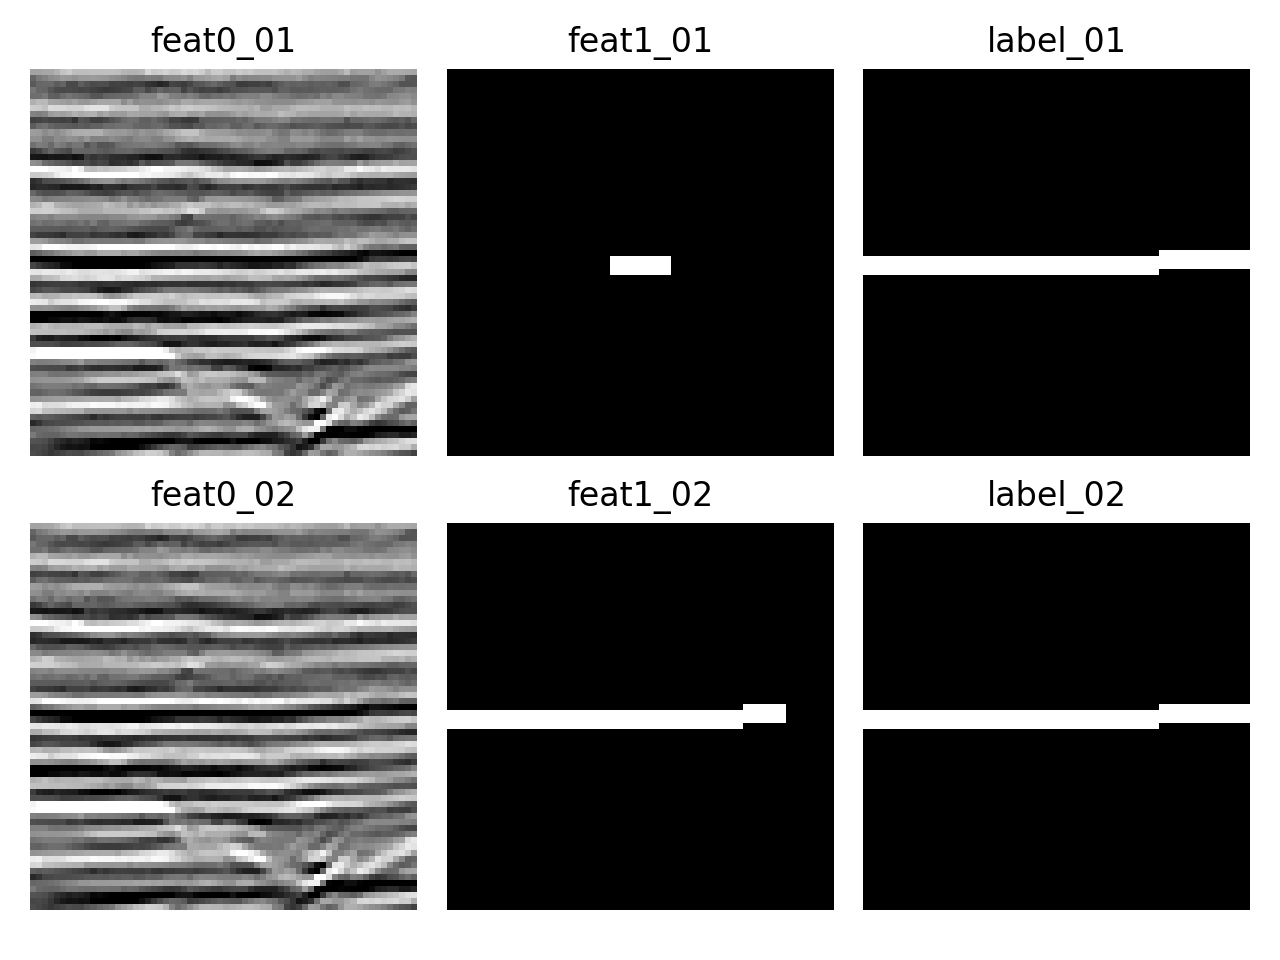

In [8]:
fig, axeslist = plt.subplots(ncols=3, nrows=2)

# DB01
axeslist.ravel()[0].imshow(db01[123].features[:, :, 0], cmap=plt.gray())
axeslist.ravel()[0].set_title('feat0_01')
axeslist.ravel()[0].set_axis_off()

axeslist.ravel()[1].imshow(db01[123].features[:, :, 1], cmap=plt.gray())
axeslist.ravel()[1].set_title('feat1_01')
axeslist.ravel()[1].set_axis_off()

axeslist.ravel()[2].imshow(db01[123].label, cmap=plt.gray())
axeslist.ravel()[2].set_title('label_01')
axeslist.ravel()[2].set_axis_off()

# DB02
axeslist.ravel()[3].imshow(db02[123].features[:, :, 0], cmap=plt.gray())
axeslist.ravel()[3].set_title('feat0_02')
axeslist.ravel()[3].set_axis_off()

axeslist.ravel()[4].imshow(db02[123].features[:, :, 1], cmap=plt.gray())
axeslist.ravel()[4].set_title('feat1_02')
axeslist.ravel()[4].set_axis_off()

axeslist.ravel()[5].imshow(db02[123].label, cmap=plt.gray())
axeslist.ravel()[5].set_title('label_02')
axeslist.ravel()[5].set_axis_off()

plt.tight_layout()


## Step 6: Saving both datasets on `HDF5` files.

In [9]:
PostStackDataDumper.to_hdf(
    train_db01,
    os.path.join(params['output_path'], 'train_db01.hdf')
)
PostStackDataDumper.to_hdf(
    valid_db01,
    os.path.join(params['output_path'], 'valid_db01.hdf')
)
PostStackDataDumper.to_hdf(
    train_db02,
    os.path.join(params['output_path'], 'train_db02.hdf')
)
PostStackDataDumper.to_hdf(
    valid_db02,
    os.path.join(params['output_path'], 'valid_db02.hdf')
)


In [10]:
params['training_examples_db01'] = len(train_db01)
params['training_examples_db02'] = len(train_db02)
params['validation_examples_db01'] = len(valid_db01)
params['validation_examples_db02'] = len(valid_db02)
params['tile_shape'] = params['tile_shape'] + (2,)

params['ones_db01'] = 0.0
params['ones_db02'] = 0.0
assert len(db01) == len(db02)
for idx in range(len(db01)):
    params['ones_db01'] += np.count_nonzero(db01[idx].label) / (params['tile_shape'][0] * params['tile_shape'][1])
    params['ones_db02'] += np.count_nonzero(db02[idx].label) / (params['tile_shape'][0] * params['tile_shape'][1])

params['ones_db01'] /= params['training_examples_db01']
params['ones_db02'] /= params['training_examples_db01']


In [11]:
with open(os.path.join(params['output_path'], 'info.json'), 'w') as f:
    json.dump(params, f, sort_keys=True, indent=2)
